In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from xgboost import XGBRegressor
from sklearn.svm import SVR
from skopt import BayesSearchCV
from skopt.space import Real, Integer






### Fixing workable df

In [25]:
df_csv = pd.read_csv('Misdrijven_W_B.csv', sep=';')
df_xls = pd.read_excel('kwb-2018.xls')
df_csv = df_csv.rename(columns={'WijkenEnBuurten': 'gwb_code_10'})
df = df_xls.merge(df_csv, on = 'gwb_code_10', how='inner')

df =df.replace({".": np.nan})

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(',', '.')
        df[col] = pd.to_numeric(df[col], errors='ignore')






C:\Users\chris\AppData\Local\Temp\ipykernel_14648\1128133705.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df =df.replace({".": np.nan})
C:\Users\chris\AppData\Local\Temp\ipykernel_14648\1128133705.py:11: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


In [26]:


numeric_cols = df.select_dtypes(include=['float64','int64']).columns
numeric_unique_counts = df[numeric_cols].nunique().sort_values()
numeric_unique_counts.head(30)

#some category collumns were changed to numeric. In this case ste_mvs
#should be converted back into a category variable

df['ste_mvs'] = df['ste_mvs'].astype('object')

### Computing missing value treshold


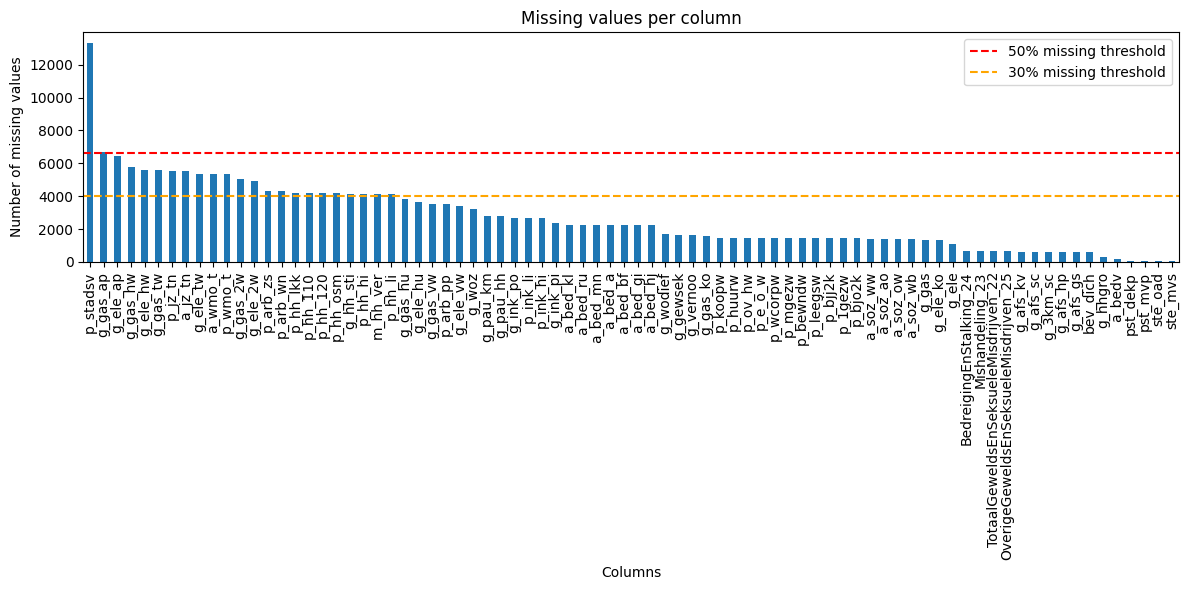

In [27]:
missing = df.isna().sum()
missing = missing[missing>0].sort_values(ascending=False)

total_rows = len(df)
missing_perc_50 = 0.5 * total_rows
missing_perc_30 = 0.3 * total_rows


plt.figure(figsize=(12,6))
missing.plot(kind='bar')
plt.axhline(missing_perc_50, color = 'red', linestyle = '--', label = '50% missing threshold')
plt.axhline(missing_perc_30, color = 'orange', linestyle = '--', label = '30% missing threshold')
plt.title("Missing values per column")
plt.ylabel("Number of missing values")
plt.xlabel("Columns")
plt.legend()
plt.tight_layout()
plt.show()

In [28]:

df = df.dropna(subset=['TotaalGeweldsEnSeksueleMisdrijven_22'])
df = df[df['a_inw']>0]

#p_stadsv has more than 50% missing values
df = df.drop(["p_stadsv"], axis=1)

#the following add up to TotaalGeweldsEnSeksueleMisdrijven_22
df = df.drop(["Mishandeling_23", "BedreigingEnStalking_24", "OverigeGeweldsEnSeksueleMisdrijven_25"], axis=1)

#redundant rows
df = df.drop(["ind_wbi", "gwb_code_8"], axis=1)

#contain several missing values and relate to criminality
df = df.drop(["g_wodief", "g_vernoo", "g_gewsek"], axis =1)

df['ste_mvs'] = df['ste_mvs'].fillna(df['ste_mvs'].mode()[0])

#--> note that i have not yet disregarded columns with missing values >30% and <50%.
# What should we do with those?

C:\Users\chris\AppData\Local\Temp\ipykernel_14648\848907292.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['ste_mvs'] = df['ste_mvs'].fillna(df['ste_mvs'].mode()[0])


### Handling outliers in dependent variable
later on we wil use population (a_inw)  and total violent crimes (TotaalGeweldsEnSeksueleMisdrijven_22) to calculate the amount of crimes per 1000. However we will run into a few problems that can be discussed in paper:
- population of zero makes infinite large numbers
- if population < total violent crimes the number blows up.
- What upper bound to choose? 

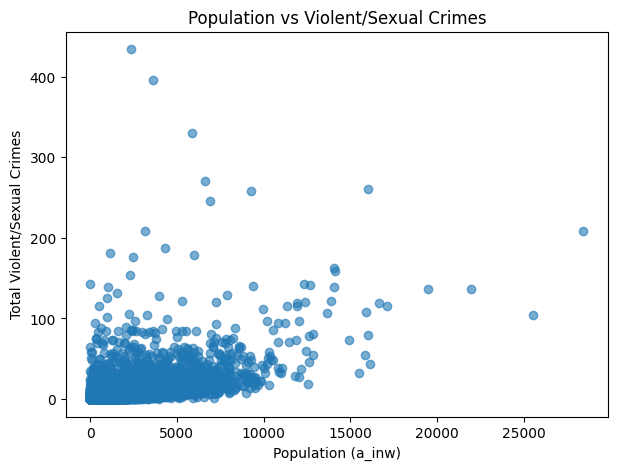

In [29]:
plt.figure(figsize=(7,5))
plt.scatter(df["a_inw"], df["TotaalGeweldsEnSeksueleMisdrijven_22"], alpha=0.6)
plt.xlabel("Population (a_inw)")
plt.ylabel("Total Violent/Sexual Crimes")
plt.title("Population vs Violent/Sexual Crimes")
plt.show()


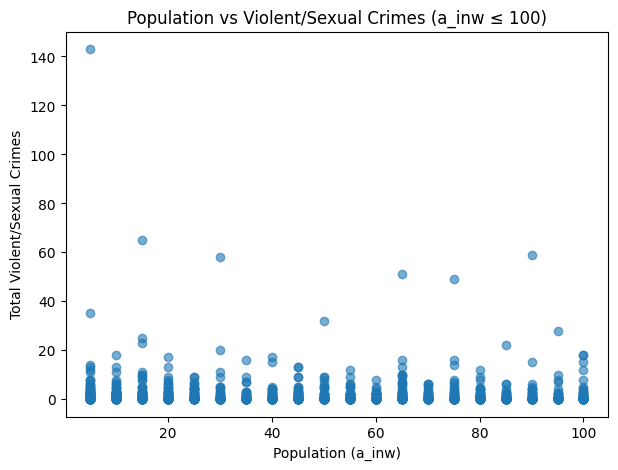

In [30]:
subset = df[df["a_inw"] <= 100]

plt.figure(figsize=(7,5))
plt.scatter(subset["a_inw"], subset["TotaalGeweldsEnSeksueleMisdrijven_22"], alpha=0.6)
plt.xlabel("Population (a_inw)")
plt.ylabel("Total Violent/Sexual Crimes")
plt.title("Population vs Violent/Sexual Crimes (a_inw ≤ 100)")
plt.show()


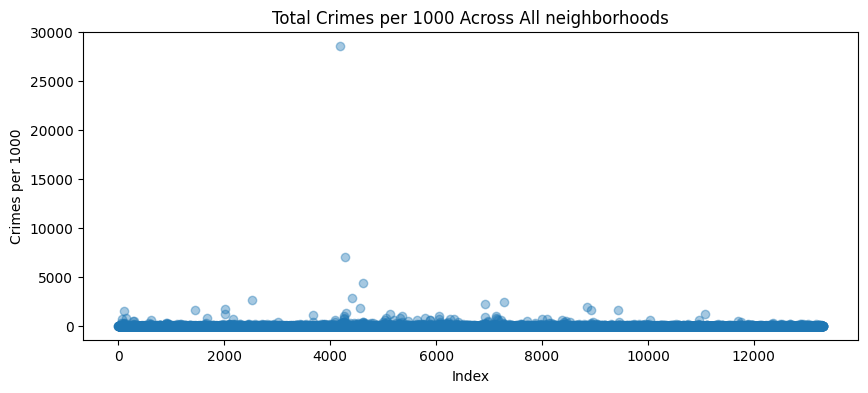

Original rows: 12381
Rows after trimming: 12060
Rows removed: 321


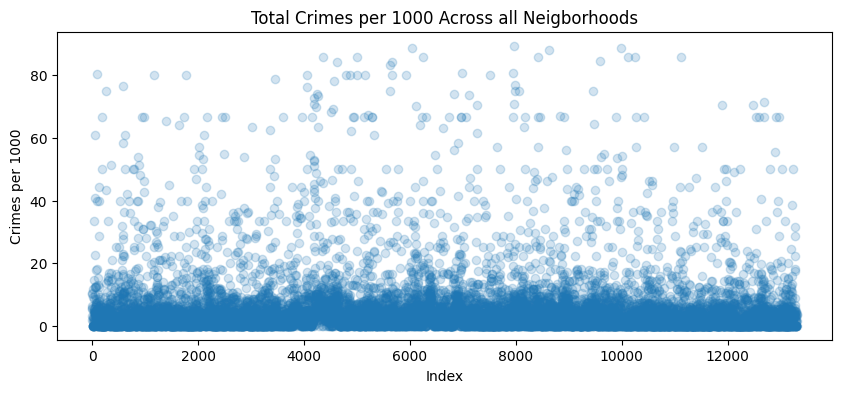

In [31]:
upper_quantile = 0.95


df["Total_Crimes_Per_1000"]= (df["TotaalGeweldsEnSeksueleMisdrijven_22"] / df["a_inw"])* 1000

df = df.dropna(subset=["Total_Crimes_Per_1000"])
df = df.drop(columns=["TotaalGeweldsEnSeksueleMisdrijven_22", "a_inw"])

plt.figure(figsize=(10,4))
plt.scatter(df.index, df["Total_Crimes_Per_1000"], alpha=0.4)
plt.title("Total Crimes per 1000 Across All neighborhoods")
plt.xlabel("Index")
plt.ylabel("Crimes per 1000")
plt.show()

Q1 = df["Total_Crimes_Per_1000"].quantile(0.25)
Q3 = df["Total_Crimes_Per_1000"].quantile(upper_quantile)
IQR = Q3 - Q1


upper_bound = Q3 + 1.5 * IQR

df_iqr = df[(df["Total_Crimes_Per_1000"] <= upper_bound)].copy()

print("Original rows:", len(df))
print("Rows after trimming:", len(df_iqr))
print("Rows removed:", len(df) - len(df_iqr))

plt.figure(figsize=(10,4))
plt.scatter(df_iqr.index, df_iqr["Total_Crimes_Per_1000"], alpha=0.2)
plt.title("Total Crimes per 1000 Across all Neigborhoods")
plt.xlabel("Index")
plt.ylabel("Crimes per 1000")
plt.show()

### train and test + scaling and imputing missing values


In [32]:
random_state = 11
df = df_iqr

y = df["Total_Crimes_Per_1000"]
X = df.drop(["Total_Crimes_Per_1000"], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= random_state)

In [33]:

#KNN imputer to fill in missing values
id_cols = ['gwb_code_10', 'regio', 'gm_naam', 'recs']
X_train = X_train.drop(id_cols, errors='ignore')
X_test = X_test.drop(id_cols, errors='ignore')


ordinal_cols = ["ste_mvs"]

num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scale_cols = [col for col in num_cols if col not in ordinal_cols]

X_train_num = X_train[scale_cols]
X_test_num = X_test[scale_cols]

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('imputer', KNNImputer(n_neighbors=5))
])

X_train_num_imputed_scaled = pipe.fit_transform(X_train_num)
X_test_num_imputed_scaled = pipe.transform(X_test_num)

X_train_num_imputed_scaled= pd.DataFrame(X_train_num_imputed_scaled, columns = scale_cols, index = X_train.index)
X_test_num_imputed_scaled= pd.DataFrame(X_test_num_imputed_scaled, columns = scale_cols, index = X_test.index)

X_train_ord = X_train[ordinal_cols]
X_test_ord = X_test[ordinal_cols]

X_train_final = pd.concat([X_train_num_imputed_scaled, X_train_ord], axis=1)
X_test_final = pd.concat([X_test_num_imputed_scaled, X_test_ord], axis=1)



### Possible feature selection (can be ignored)

In [11]:
#feature selection 
feature_selection = SelectKBest(score_func=mutual_info_regression, k=20)

feature_selection.fit(X_train_final, y_train)
X_train_selected = feature_selection.transform(X_train_final)
X_test_selected = feature_selection.transform(X_test_final)

selected_features = X_train_final.columns[feature_selection.get_support()]
print("Selected features:", list(selected_features))

Selected features: ['a_man', 'a_vrouw', 'a_00_14', 'a_15_24', 'a_25_44', 'a_45_64', 'a_ongeh', 'a_gehuwd', 'a_gesch', 'a_hh', 'a_1p_hh', 'a_hh_z_k', 'a_hh_m_k', 'a_woning', 'a_inkont', 'a_soz_wb', 'a_soz_ao', 'a_soz_ww', 'a_pau', 'a_bst_b']


### Data exploration for selected features

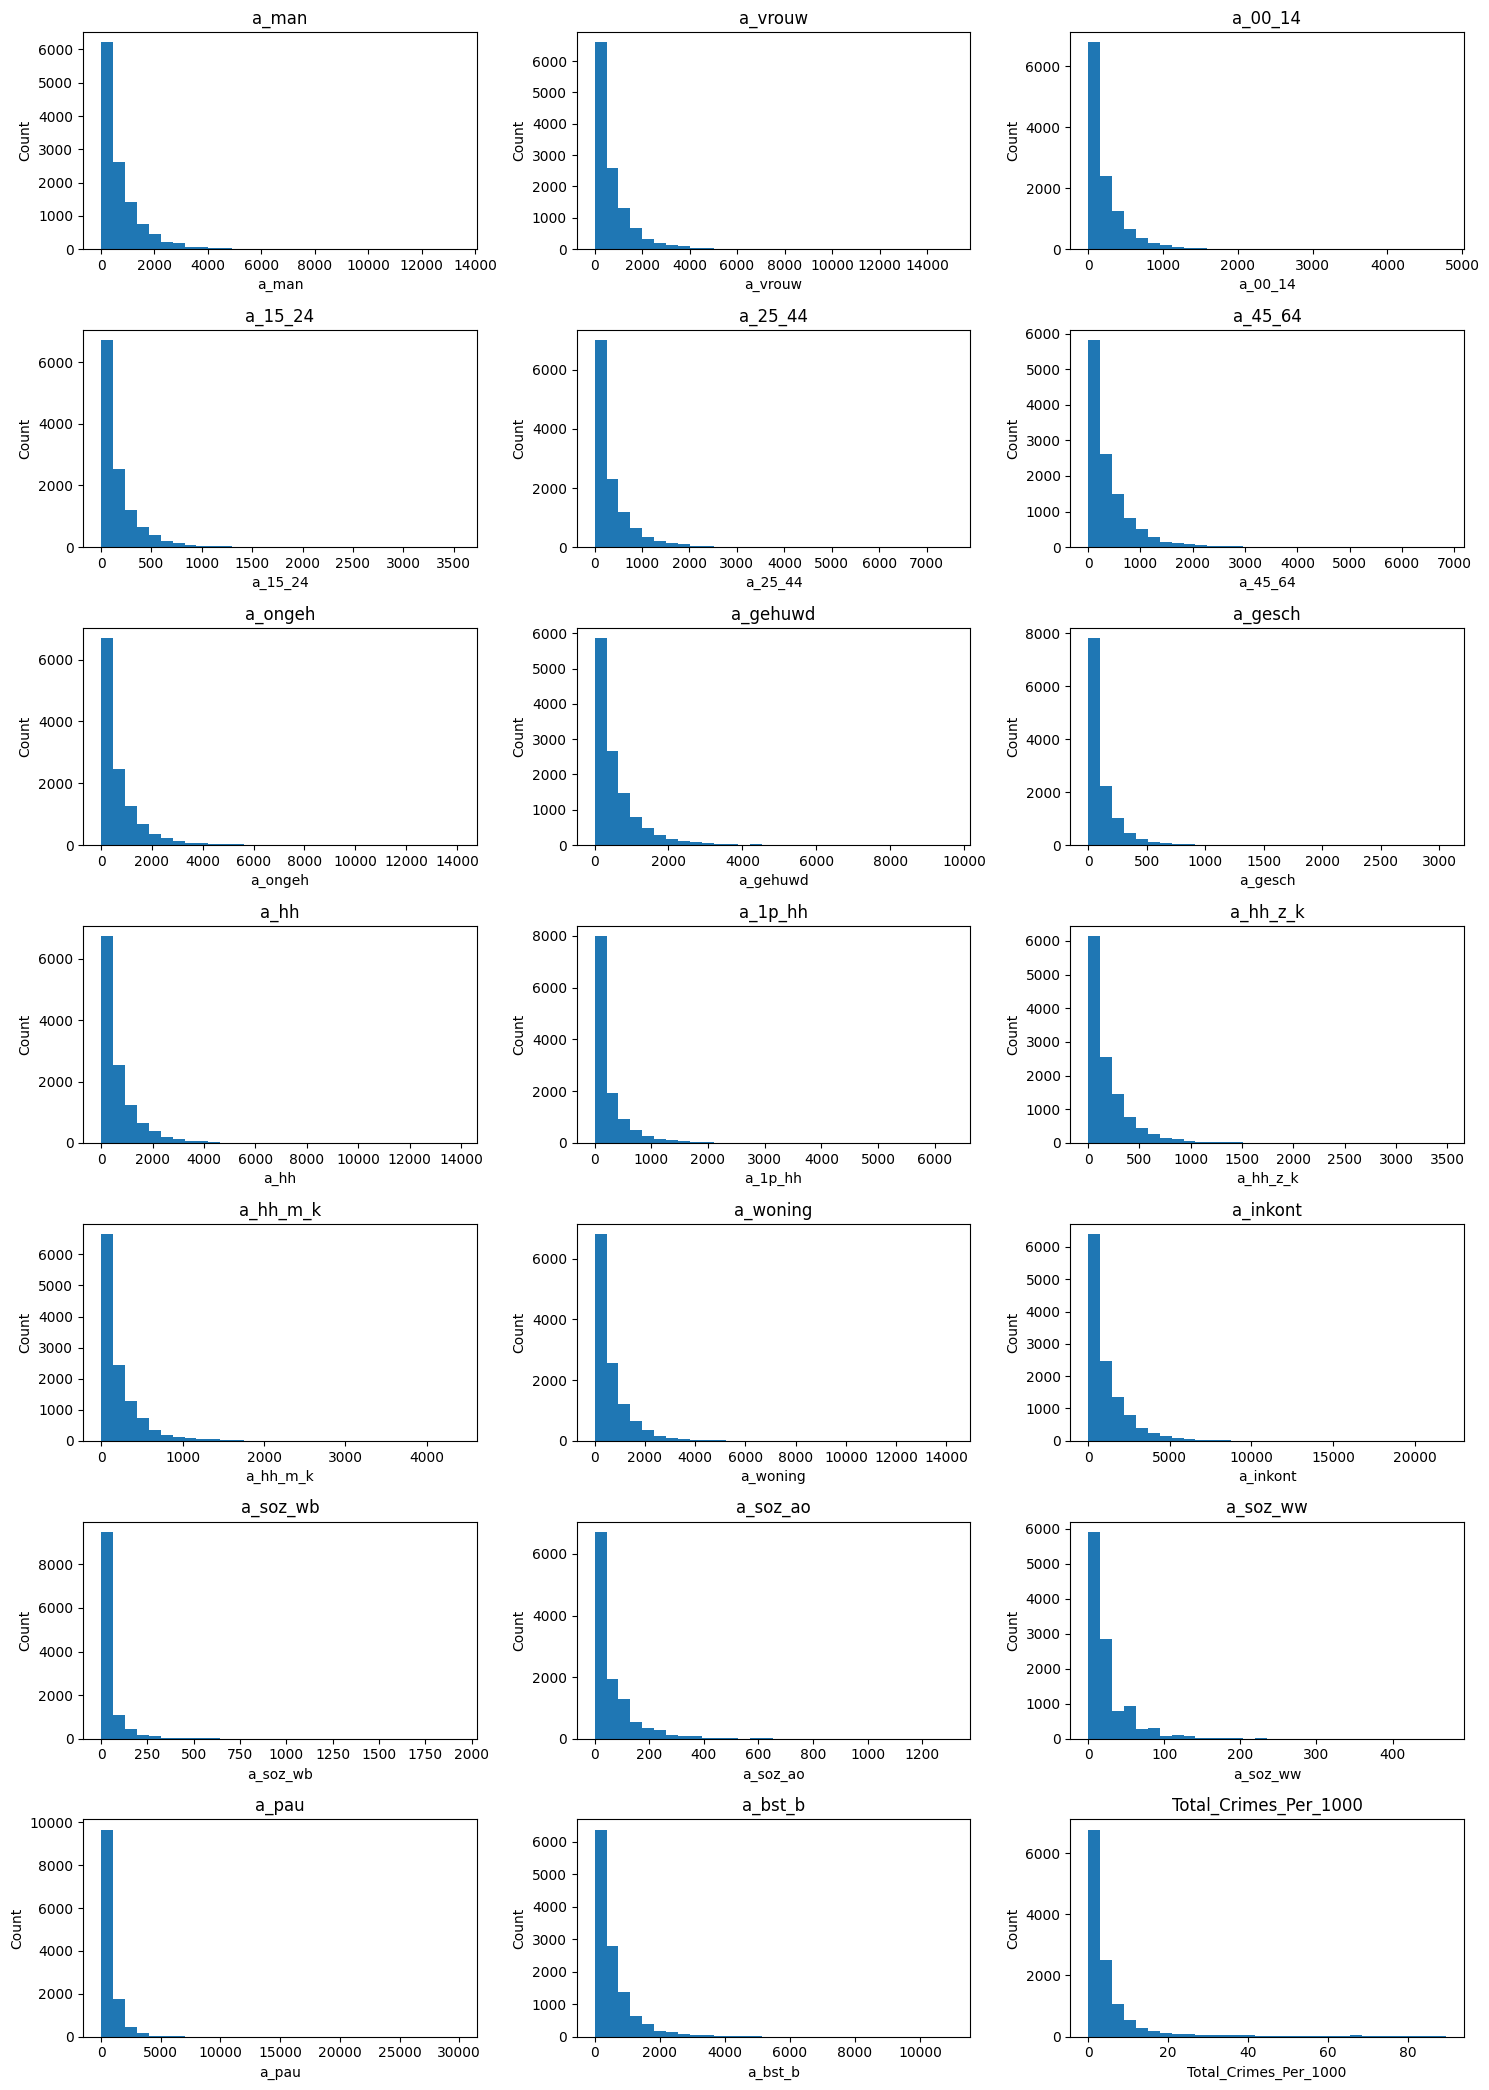

In [12]:
feature_cols = list(selected_features)
target_col = "Total_Crimes_Per_1000"

cols = feature_cols + [target_col]
n_cols = 3
n_rows = int(np.ceil(len(cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 3))
axes = axes.flatten()

for i, col in enumerate(cols):
    axes[i].hist(df[col].values, bins=30)
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

plt.tight_layout()
plt.show()


### ElasticNet

In [13]:
#elasticNet

elastic = ElasticNetCV(
    l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
    alphas=None,
    cv=5,
    random_state=random_state
)

elastic.fit(X_train_final, y_train)
y_pred_elastic = elastic.predict(X_test_final)

print("ElasticNet Results:")
print("R2 Score:", r2_score(y_test, y_pred_elastic))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred_elastic))
print("Best Alpha:", elastic.alpha_)
print("Best L1 Ratio:", elastic.l1_ratio_)



c:\Users\chris\Desktop\ML-Final_Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1682: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\chris\Desktop\ML-Final_Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.064e+01, tolerance: 7.831e+01
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\chris\Desktop\ML-Final_Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.474e+02, tolerance: 7.831e+0

ElasticNet Results:
R2 Score: 0.2790678158326171
Mean Squared Error: 65.49119612397007
Best Alpha: 0.004321760462877142
Best L1 Ratio: 0.7


c:\Users\chris\Desktop\ML-Final_Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.439e+05, tolerance: 9.429e+01
  model = cd_fast.enet_coordinate_descent(


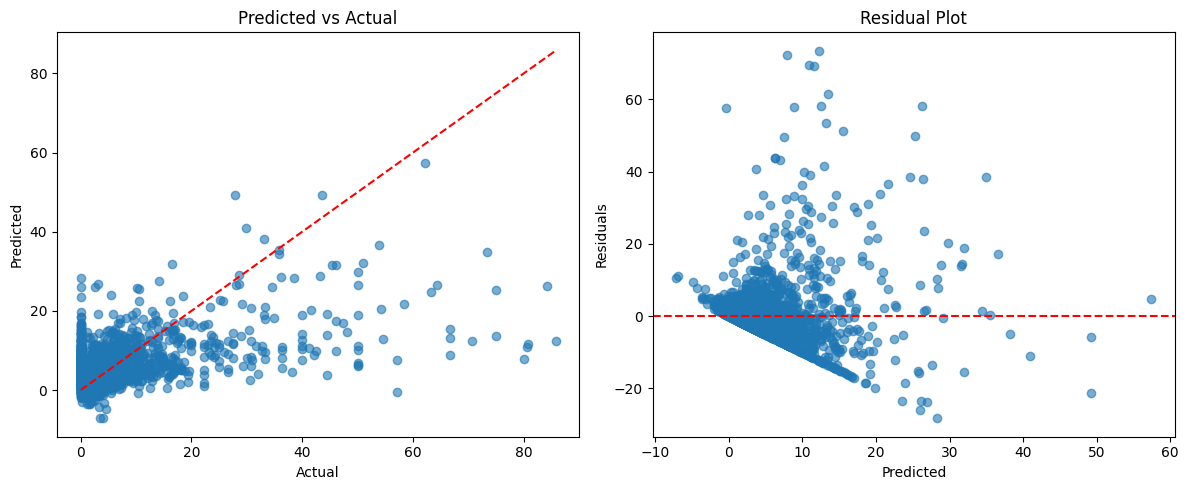

In [14]:

residuals = y_test - y_pred_elastic

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_elastic, alpha=0.6)
plt.plot([y_test.min(),y_test.max()],[y_test.min(), y_test.max()],'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")


plt.subplot(1, 2, 2)
plt.scatter(y_pred_elastic, residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()


### Random Forest

In [15]:
rf_regressor = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_regressor.fit(X_train_final, y_train)

rf_train_r2 = rf_regressor.score(X_train_final, y_train)
rf_test_r2 = rf_regressor.score(X_test_final, y_test)

print(f"Training R2: {rf_train_r2:.4f}")
print(f"Test R2: {rf_test_r2:.4f}")
print(f"Overfitting gap: {rf_train_r2 - rf_test_r2:.4f}")

y_pred = rf_regressor.predict(X_test_final)
rmse = mean_squared_error(y_test, y_pred)
print(f"Test RMSE: {rmse:.4f}")


Training R2: 0.8976
Test R2: 0.2697
Overfitting gap: 0.6280
Test RMSE: 66.3438


In [16]:
param_grid_rf = {
    'max_depth': [5, 10, 15, 20, None],
    'n_estimators': [50, 100, 200]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=random_state, n_jobs=-1),
    param_grid_rf,
    cv=3,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_final, y_train)

print(f"\nBest parameters:")
print(f"  max_depth: {grid_rf.best_params_['max_depth']}")
print(f"  n_estimators: {grid_rf.best_params_['n_estimators']}")

rf_tuned_train_r2 = grid_rf.score(X_train_final, y_train)
rf_tuned_test_r2 = grid_rf.score(X_test_final, y_test)
print(f"Training R2: {rf_tuned_train_r2:.4f}")
print(f"Test R2: {rf_tuned_test_r2:.4f}")
print(f"Accuracy difference: {rf_tuned_train_r2 - rf_tuned_test_r2:.4f}")

Fitting 3 folds for each of 15 candidates, totalling 45 fits

Best parameters:
  max_depth: 10
  n_estimators: 200
Training R2: 0.7203
Test R2: 0.2848
Accuracy difference: 0.4355


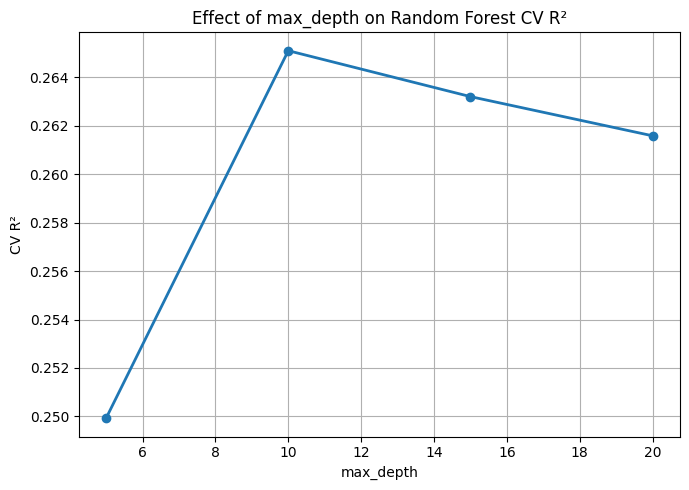

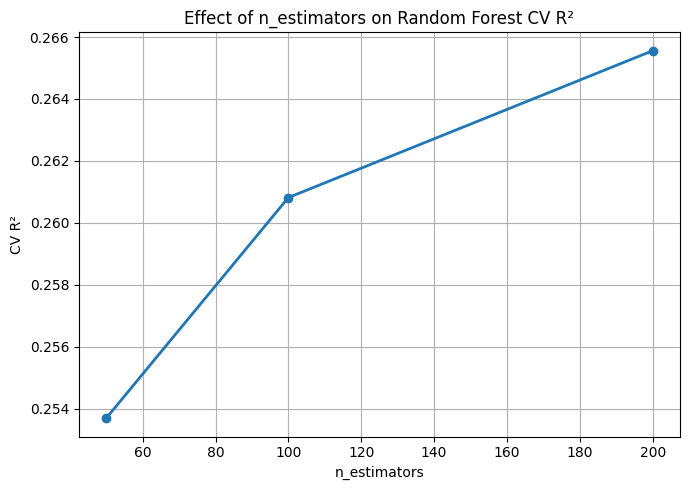

In [17]:
results = pd.DataFrame(grid_rf.cv_results_)

plt.figure(figsize=(7,5))

depth_scores = results.groupby("param_max_depth")["mean_test_score"].mean()

plt.plot(depth_scores.index, depth_scores.values, marker='o', linewidth=2)
plt.xlabel("max_depth")
plt.ylabel("CV R²")
plt.title("Effect of max_depth on Random Forest CV R²")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))

est_scores = results.groupby("param_n_estimators")["mean_test_score"].mean()

plt.plot(est_scores.index, est_scores.values, marker='o', linewidth=2)
plt.xlabel("n_estimators")
plt.ylabel("CV R²")
plt.title("Effect of n_estimators on Random Forest CV R²")
plt.grid(True)
plt.tight_layout()
plt.show()


Model Comparison

In [35]:
X_train_model = X_train_final
X_test_model = X_test_final

print("X_train_model shape:", X_train_model.shape)
print("X_test_model shape:", X_test_model.shape)

models = {}

# 1) ElasticNet (no extra scaler here; you've already scaled numerics in the pipeline above)
models["ElasticNet"] = ElasticNet(alpha=0.01, l1_ratio=0.7, random_state=42)

# 2) Random Forest
models["RandomForest"] = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,       
    n_jobs=-1,
    random_state=42
)

# 3) XGBoost
models["XGBoost"] = XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=1.0,
    colsample_bytree=1.0,
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# 4) SVM (SVR with RBF kernel) on PCA-reduced features
models["SVR_RBF"] = Pipeline([
    ("pca", PCA(n_components=20, random_state=42)), 
    ("model", SVR(kernel="rbf", C=1.0, epsilon=0.1))
])

# ==== 2. Train, predict, and collect metrics ====

results = []

for name, model in models.items():
    print(f"\n===== {name} =====")
    
    # Fit
    model.fit(X_train_model, y_train)
    
    # Predict
    y_train_pred = model.predict(X_train_model)
    y_test_pred = model.predict(X_test_model)
    
    # Metrics
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    
    print(f"Train R2: {r2_train:.4f}")
    print(f"Test  R2: {r2_test:.4f}")
    print(f"Test  MSE: {mse_test:.4f}")
    print(f"Test  RMSE: {rmse_test:.4f}")
    print(f"Overfitting gap (Train - Test R2): {r2_train - r2_test:.4f}")
    
    results.append({
        "model": name,
        "train_R2": r2_train,
        "test_R2": r2_test,
        "overfit_gap": r2_train - r2_test,
        "test_MSE": mse_test,
        "test_RMSE": rmse_test
    })

# ==== 3. Comparison table ====

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("test_R2", ascending=False)
print("\n\n=== Model comparison ===")
print(results_df.to_string(index=False))

X_train_model shape: (9648, 108)
X_test_model shape: (2412, 108)

===== ElasticNet =====


c:\Users\chris\Desktop\ML-Final_Project\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:716: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.305e+04, tolerance: 9.429e+01
  model = cd_fast.enet_coordinate_descent(


Train R2: 0.2583
Test  R2: 0.2786
Test  MSE: 65.5341
Test  RMSE: 8.0953
Overfitting gap (Train - Test R2): -0.0203

===== RandomForest =====
Train R2: 0.8999
Test  R2: 0.2821
Test  MSE: 65.2194
Test  RMSE: 8.0759
Overfitting gap (Train - Test R2): 0.6178

===== XGBoost =====
Train R2: 0.9396
Test  R2: 0.3217
Test  MSE: 61.6153
Test  RMSE: 7.8495
Overfitting gap (Train - Test R2): 0.6179

===== SVR_RBF =====
Train R2: 0.0762
Test  R2: 0.0747
Test  MSE: 84.0570
Test  RMSE: 9.1683
Overfitting gap (Train - Test R2): 0.0015


=== Model comparison ===
       model  train_R2  test_R2  overfit_gap  test_MSE  test_RMSE
     XGBoost  0.939608 0.321734     0.617874 61.615326   7.849543
RandomForest  0.899870 0.282059     0.617810 65.219426   8.075855
  ElasticNet  0.258343 0.278596    -0.020253 65.534085   8.095313
     SVR_RBF  0.076172 0.074694     0.001478 84.056991   9.168260


XGBoost Bayesian optimization (best performer)

In [37]:
param_space = {
    "max_depth": Integer(2, 12),
    "learning_rate": Real(0.01, 0.3, prior="log-uniform"),
    "n_estimators": Integer(50, 500),
    "colsample_bytree": Real(0.5, 1.0),
    "subsample": Real(0.5, 1.0),
    "min_child_weight": Integer(1, 10)
}

xgb_base = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

opt = BayesSearchCV(
    estimator=xgb_base,
    search_spaces=param_space,
    n_iter=25,            
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=1,
    random_state=42
)

opt.fit(X_train_model, y_train)

print("Best parameters:", opt.best_params_)
print("Best CV score:", opt.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fi

Final model with best Parameters

In [39]:
best_xgb = opt.best_estimator_

y_train_pred = best_xgb.predict(X_train_model)
y_test_pred = best_xgb.predict(X_test_model)

print("Final XGBoost after Bayesian Optimization:")
print("Train R2:", r2_score(y_train, y_train_pred))
print("Test  R2:", r2_score(y_test, y_test_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test RMSE:", rmse)


Final XGBoost after Bayesian Optimization:
Train R2: 0.9029284482918901
Test  R2: 0.33286405570572
Test RMSE: 7.784871071953605


Feature importance

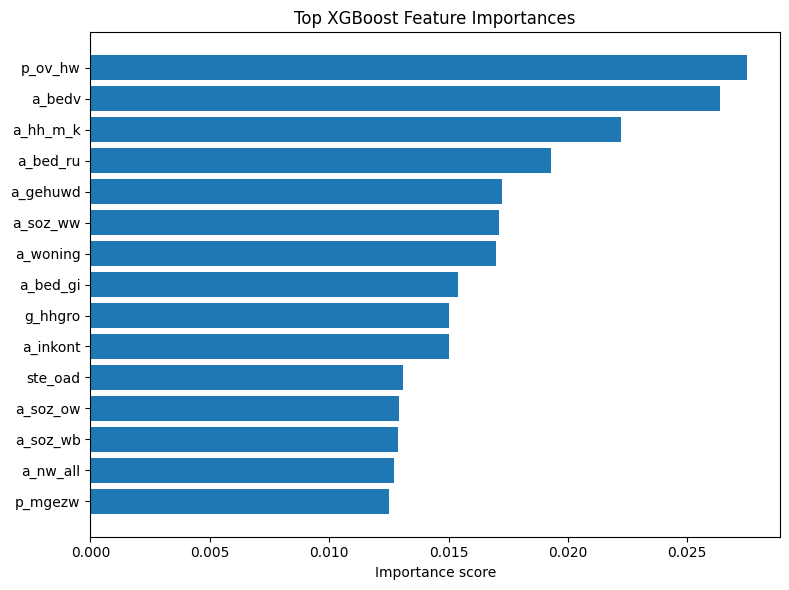

In [40]:
importance = best_xgb.feature_importances_

feat_imp = pd.DataFrame({
    "feature": X_train_model.columns,
    "importance": importance
}).sort_values("importance", ascending=False)

feat_imp.head(20)
top_k = 15
top = feat_imp.head(top_k).sort_values("importance")

plt.figure(figsize=(8, 6))
plt.barh(top["feature"], top["importance"])
plt.title("Top XGBoost Feature Importances")
plt.xlabel("Importance score")
plt.tight_layout()
plt.show()

SHAP analyse 

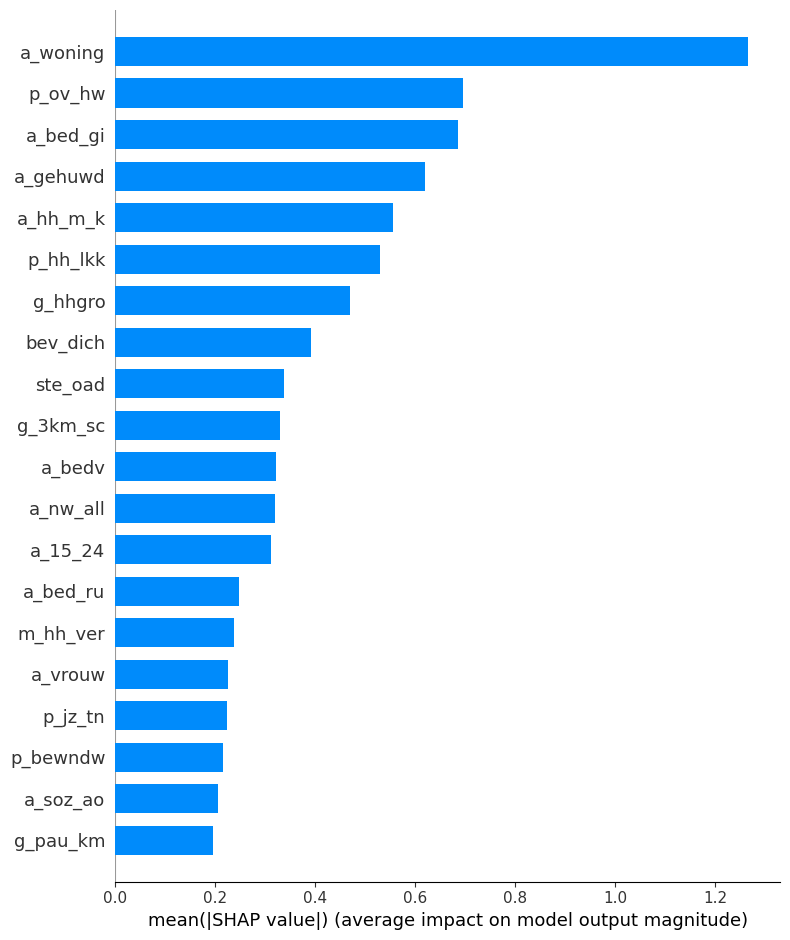

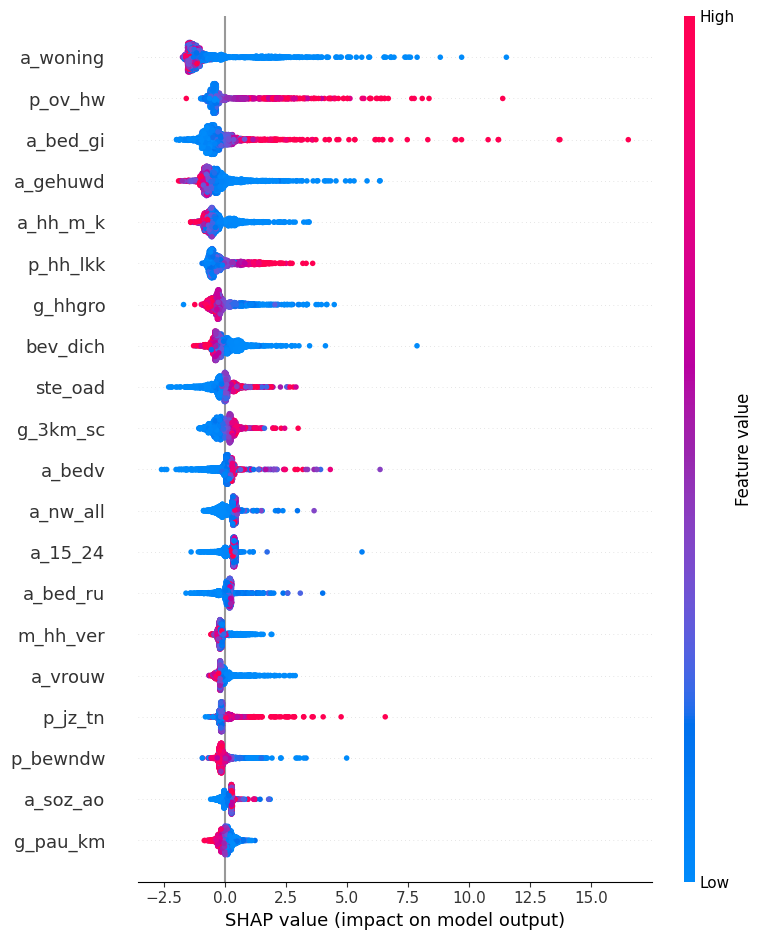

In [43]:
model = best_xgb

sample_idx = np.random.choice(X_train_model.index, size=2000, replace=False)
X_sample = X_train_model.loc[sample_idx]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values, X_sample, plot_type="bar")
shap.summary_plot(shap_values, X_sample)

X_all shape: (12060, 108)
y_all shape: (12060,)
Explained variance ratio (PC1, PC2): [0.36489845 0.13081014]
Total explained variance (2 PCs): 0.4957085831756469
Silhouette score for k=5: 0.406


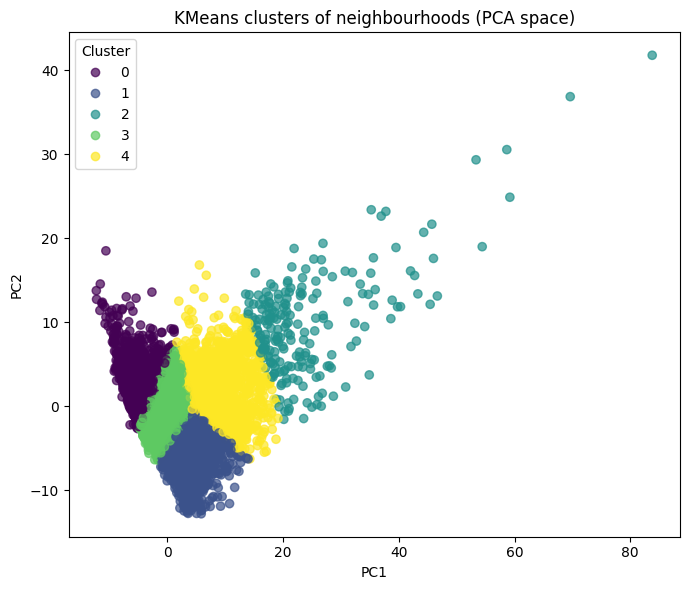

In [47]:
X_all = pd.concat([X_train_final, X_test_final], axis=0)
y_all = y.loc[X_all.index] 

print("X_all shape:", X_all.shape)
print("y_all shape:", y_all.shape)

scaler_clust = StandardScaler()
X_all_scaled = scaler_clust.fit_transform(X_all)

pca = PCA(n_components=2, random_state=random_state)
X_all_pca = pca.fit_transform(X_all_scaled)

print("Explained variance ratio (PC1, PC2):", pca.explained_variance_ratio_)
print("Total explained variance (2 PCs):", pca.explained_variance_ratio_.sum())

k = 5
kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
labels = kmeans.fit_predict(X_all_pca)

sil = silhouette_score(X_all_pca, labels)
print(f"Silhouette score for k={k}: {sil:.3f}")

plt.figure(figsize=(7, 6))
scatter = plt.scatter(X_all_pca[:, 0], X_all_pca[:, 1], c=labels, alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans clusters of neighbourhoods (PCA space)")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()

In [48]:
cluster_df = pd.DataFrame({
    "cluster": labels,
    "crime_rate": y_all.values
})

cluster_stats = cluster_df.groupby("cluster")["crime_rate"].agg(
    ["mean", "median", "std", "count"]
).sort_index()

cluster_stats

,mean,median,std,count
cluster,,,,
0,5.441748,0.000000,11.852107,4286
1,7.851331,5.341659,9.492066,1976
2,6.105595,4.660010,6.097606,213
3,4.108992,1.796407,8.774283,4046
4,4.416817,3.115265,5.276554,1539


Cluster Feature Importance

In [49]:
top_features = feat_imp.head(10)["feature"].tolist()
print("Top features for profiling:", top_features)

X_all_with_labels = X_all.copy()
X_all_with_labels["cluster"] = labels
X_all_with_labels["crime_rate"] = y_all.values

cluster_profiles = X_all_with_labels.groupby("cluster")[top_features + ["crime_rate"]].mean()

cluster_profiles

Top features for profiling: ['p_ov_hw', 'a_bedv', 'a_hh_m_k', 'a_bed_ru', 'a_gehuwd', 'a_soz_ww', 'a_woning', 'a_bed_gi', 'g_hhgro', 'a_inkont']


,p_ov_hw,a_bedv,a_hh_m_k,a_bed_ru,a_gehuwd,a_soz_ww,a_woning,a_bed_gi,g_hhgro,a_inkont,crime_rate
cluster,,,,,,,,,,,
0,0.064520,-0.414364,-0.588389,-0.531512,-0.601908,-0.640868,-0.630891,-0.354564,0.638459,-0.626146,5.441748
1,0.189651,-0.123934,-0.046803,-0.009975,-0.110310,0.076141,0.144112,-0.038342,-1.026210,0.055877,7.851331
2,0.263788,3.835248,4.328613,3.378488,3.928316,4.358440,4.442102,2.913946,-0.489490,4.394496,6.105595
3,-0.100497,-0.202823,-0.130943,-0.261091,-0.092834,-0.196302,-0.202213,-0.219673,-0.009063,-0.174582,4.108992
4,0.055947,1.289067,1.419715,1.134042,1.487496,1.333423,1.468504,0.909643,-0.357273,1.502923,4.416817
